In [1]:
!pip install hazm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 892.6/892.6 kB 4.2 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 44.5 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 70.0 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.6.1 requires cubinlinker, which is not installed.
cudf 24.6.1 requires cupy-cuda11x>=12.0.0, which is

In [2]:
!pip install gdown

In [3]:
import gdown

file_url = 'https://drive.google.com/uc?id=1jLPU74F21WJvHyR7hApnTVg7Za14eY6D'
output = 'news_data.csv'
gdown.download(file_url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1jLPU74F21WJvHyR7hApnTVg7Za14eY6D
From (redirected): https://drive.google.com/uc?id=1jLPU74F21WJvHyR7hApnTVg7Za14eY6D&confirm=t&uuid=93313b8d-e96d-44b0-8234-66716e44e710
To: /kaggle/working/news_data.csv
100%|██████████| 335M/335M [00:03<00:00, 103MB/s]  


'news_data.csv'

In [159]:
# Standard library imports
import os
import re
import string

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from keras.models import Model, Sequential
from keras.layers import (Input, LSTM, Dense, Dot, Activation, Concatenate, Dropout,
                          Flatten, Permute, Layer, GlobalMaxPooling2D, Embedding,
                          Bidirectional, TimeDistributed, Lambda, BatchNormalization)
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from hazm import *
from gensim.models import Word2Vec

normalizer = Normalizer()
stemmer = Stemmer()
lemmatizer = Lemmatizer()

PreProcess

In [151]:
file_path = "/kaggle/working/news_data.csv"
dataset = pd.read_csv(file_path)

In [152]:
dataset

,Unnamed: 0,title,subgroup,abstract,body
0,3,معاون رئیسی: مردم به زودی شاهد اثرات مثبت اقدا...,سیاسی,معاون امور مجلس رئیس جمهور: استان گیلان دارای ...,معاون رئیس جمهور گفت: دولت برنامه های راهبردی ...
1,6,معاون وزیر اطلاعات: فضای مجازی بلای خانمان سوز...,سیاسی,مقام معظم رهبری بیان کردند اگر رهبر نبودند مسئ...,معاون سیاسی، فرهنگی و اجتماعی وزارت اطلاعات گف...
2,7,آبکش شدن با 60 گلوله پلیس؛ تاوان فرار یک جوان ...,سیاسی,خانواده این جوان 25 ساله آمریکایی گفته اند رفت...,یک جوان سیاه پوست در شهر آکرون ایالت اوهایو آم...
3,8,درگذشت دانشجوی دانشگاه فرهنگیان,حوادث,"""متین حبیب لی"" دانشجومعلم رشته آموزش ابتدایی ۹...",دانشگاه فرهنگیان با صدور پیامی، درگذشت یکی از ...
4,10,زاهدان/ غرق شدن 3 کودک در ظروف ذخیره آب خانگی,حوادث,گاهی مردم با قطعی آب روبه رو هستند. از این رو ...,بر اثر افت فشار و یا قطعی آب در برخی نقاط حاشی...
...,...,...,...,...,...
96425,237875,خروج بانک سپه از تلگرام و حضور در پیام‌رسان‌ها...,اقتصادی,بانک سپه اعلام کرد: با توجه به تأکیدات و رهنمو...,بنابر اعلام بانک سپه، این بانک همگام با دستگاه...
96426,237879,معاون وزیر ارشاد: مخالف انحصار صداوسیما هستیم,سیاسی,قطعا با هرگونه انحصار در فعالیت‌های فراگیر مرد...,معاون مطبوعاتی وزیر ارشاد گفت: انحصار صدور مجو...
96427,237880,دیدار دست‌اندرکاران همایش حکیم تهران با مقام م...,سیاسی,حذف فلسفه از حوزه علمیه قم موجب خواهد شد افراد...,پایگاه اطلاع رسانی مقام معظم رهبری نوشت: بیانا...
96428,237882,واردات گوشی تلفن همراه از خودرو جلو زد,اقتصادی,در فروردین ماه امسال­­ تعداد 249 هزار و 154 دس...,براساس آمار گمرک ایران در­ فروردین ماه امسال ­...


In [153]:
dataset =  dataset.drop(columns=['Unnamed: 0'])

In [154]:
# Pre-compile regex patterns for efficiency
website_pattern = re.compile(r'https?://\S+|www\.\S+')
email_pattern = re.compile(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b')
number_pattern = re.compile(r'[0-9۰-۹]+')
english_pattern = re.compile(r'[a-zA-Z]+')
repeated_char_pattern = re.compile(r'(.)\1+')
english_punctuation = string.punctuation
persian_punctuation = "،؛؟«»"
all_punctuation = english_punctuation + persian_punctuation
unnecessary_chars = set(all_punctuation)

def clean_text(text):
    text = str(text).replace('\u200c', ' ')
    text = re.sub(website_pattern, ' ', text)
    text = re.sub(email_pattern, ' ', text)
    text = re.sub(number_pattern, ' ', text)
    text = re.sub(english_pattern, ' ', text)
    text = re.sub(repeated_char_pattern, r'\1', text)
    text = ''.join(char if char.isalnum() or char.isspace() else ' ' for char in text)
    text = ' '.join(text.split())
    return text


def normalization(text):
    normalized_text = normalizer.normalize(text)
    return normalized_text

def tokenization(text):
    tokens = word_tokenize(text)
    return tokens

def get_stop_words(self):
    with open("stop_words.txt", 'r', encoding='utf-8') as file:
        stop_words = set(word.strip() for word in file.readlines())
    return stop_words

def handle_missed():
    dataset['abstract'] = dataset['abstract'].fillna('')
    dataset['body'] = dataset['body'].fillna('')


def find_stop_words(tfidf_vectorizer):
    idf_scores = tfidf_vectorizer.idf_
    feature_names = tfidf_vectorizer.get_feature_names_out()
    max_idf_threshold = 11
    min_idf_threshold = 2
    stop_words = [word for word, score in zip(feature_names, idf_scores) if not (min_idf_threshold <=score <= max_idf_threshold)]
    print(len(stop_words))
    with open("stop_words.txt", 'w', encoding='utf-8') as file:
        for word in stop_words:
            file.write(word + '\n')
    print("Stop words saved to: stop_words.txt")

def get_stop_words():
        with open("stop_words.txt", 'r', encoding='utf-8') as file:
            stop_words = set(word.strip() for word in file.readlines())
        return stop_words

def remove_stop_words(tokens, stop_words):
    filtered_tokens = [token for token in tokens if token not in stop_words]
    return filtered_tokens

def remove_unnecessary_characters(words):
    filtered_tokens = [token for token in words if token not in unnecessary_chars]
    return filtered_tokens

def stemming(tokens):
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens


def lemmatizing(tokens):
    lemmatized_words = [lemmatizer.lemmatize(word) for word in tokens]

    def handle_special_token(tokens):
        filtered_tokens = []
        for token in tokens:
            parts = token.split('#')
            if len(parts) == 1:
                filtered_tokens.append(token)
                continue
            filtered_tokens.append(parts[1])
        return filtered_tokens

    lemmatized_words = handle_special_token(lemmatized_words)
    return lemmatized_words

In [155]:
handle_missed()
dataset['text'] = dataset['title'] + ' ' + dataset['abstract'] + ' ' + dataset['body']
dataset['text'] = dataset['text'].apply(clean_text)

In [156]:
dataset['text'] = dataset['text'].apply(normalization)
dataset['tokens'] = dataset['text'].apply(tokenization)

In [157]:
tfidf_vectorizera = TfidfVectorizer()
tfidf_vectorizera.fit(dataset['text'].values)
find_stop_words(tfidf_vectorizera)

91347
Stop words saved to: stop_words.txt


In [188]:
stop_words = get_stop_words()
dataset['filtered_tokens'] = dataset['tokens'].apply(lambda tokens: remove_stop_words(tokens, stop_words))

In [189]:
dataset['filtered_tokens'] = dataset['filtered_tokens'].apply(remove_unnecessary_characters)
dataset['filtered_tokens'] = dataset['filtered_tokens'].apply(lemmatizing)

# dataset['filtered_tokens'] = dataset['filtered_tokens'].apply(stemming)

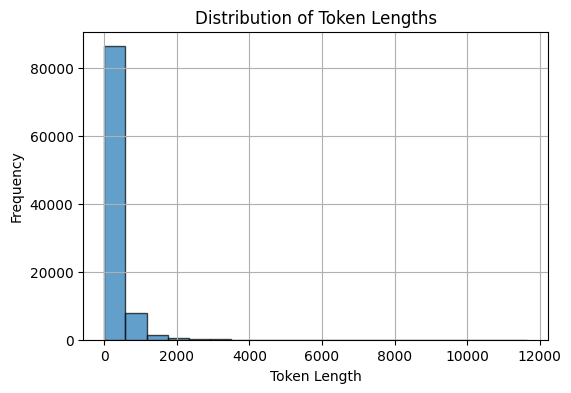

In [190]:
length = dataset['filtered_tokens'].apply(len)

plt.figure(figsize=(6, 4))
plt.hist(length, bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of Token Lengths')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [191]:
input_shape = 512
wv_model = Word2Vec(sentences=dataset['filtered_tokens'], vector_size=input_shape, window=8, min_count=1, workers=4)

In [192]:
def document_vector(doc):
    words = [word for word in doc if word in wv_model.wv]
    if words:
        return np.mean(wv_model.wv[words], axis=0)
    else:
        return np.zeros(input_shape)

In [193]:
def document_vector_tfidf(doc):
    doc_words = [word for word in doc if word in wv_model.wv]
    weights = tfidf_vectorizera.transform([' '.join(doc_words)]).toarray()
    weighted_vec = np.zeros((wv_model.vector_size,))
    total_weight = 0
    for i, word in enumerate(doc_words):
        weight = weights[0, tfidf_vectorizera.vocabulary_.get(word, 0)]
        weighted_vec += weight * wv_model.wv[word]
        total_weight += weight
    if total_weight > 0:
        weighted_vec /= total_weight
    return weighted_vec

In [194]:
# embeddings = [list(document_vector_tfidf(doc)) for doc in dataset['filtered_tokens']]

In [195]:
embeddings = [list(document_vector(doc)) for doc in dataset['filtered_tokens']]

In [196]:
dataset['embedding'] = embeddings

In [197]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(dataset['subgroup'])

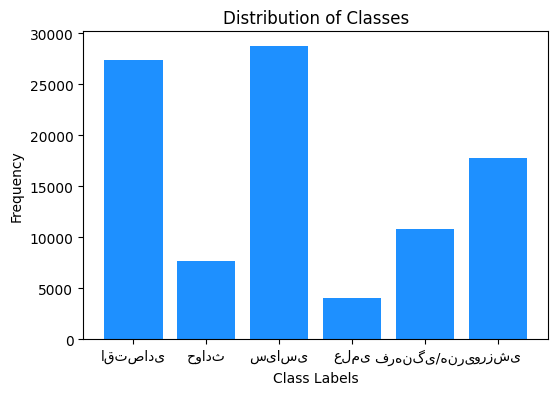

In [198]:
unique, counts = np.unique(labels, return_counts=True)
plt.figure(figsize=(6, 4))
plt.bar(unique, counts, color='dodgerblue')
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.title('Distribution of Classes')
plt.xticks(unique, [label_encoder.inverse_transform([int(i)])[0] for i in unique])
plt.show()

In [199]:
data = np.array(dataset['embedding'].tolist())
print(f"Embeddings shape: {data.shape}")
data = data.reshape(data.shape[0], 1, data.shape[1])

Embeddings shape: (96430, 512)


In [200]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

Balance

In [173]:
# from imblearn.over_sampling import SMOTE
# import numpy as np

# print(f"Original X_train shape: {X_train.shape}")
# X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
# smote = SMOTE(random_state=42)
# X_res, y_res = smote.fit_resample(X_train_reshaped, y_train)
# X_res = X_res.reshape(X_res.shape[0], 1, X_res.shape[1])
# print(f"Resampled X_res shape: {X_res.shape}")
# unique, counts = np.unique(y_res, return_counts=True)
# class_counts = dict(zip(unique, counts))
# print(f"Class counts after resampling: {class_counts}")

In [201]:
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], 1),
                                 initializer='glorot_uniform', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[1], 1),
                                 initializer='zeros', trainable=True)
        super(AttentionLayer, self).build(input_shape)
        
    def call(self, x):
        e = tf.keras.activations.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)

In [213]:

hidden_dim = data.shape[2]
model = Sequential([
    Input(shape=(1, data.shape[2])),
    Bidirectional(LSTM(hidden_dim, return_sequences=True, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01))),
    Dropout(0.2),
    AttentionLayer(),
    Dense(hidden_dim//2, activation='relu'),
    BatchNormalization(),
    Dense(hidden_dim//4, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_24                │ (None, 1, 1024)        │     4,198,400 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 1, 1024)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer_24              │ (None, 1024)           │         1,025 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,496,519 (17.15 MB)

 Trainable params: 4,496,007 (17.15 MB)

 Non-trainable params: 512 (2.00 KB)

In [214]:
history = model.fit(X_train, y_train, epochs=100, batch_size=128, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
483/483 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.8753 - loss: 4.2921 - val_accuracy: 0.8823 - val_loss: 0.4751
Epoch 2/100
483/483 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8920 - loss: 0.4381 - val_accuracy: 0.8863 - val_loss: 0.4523
Epoch 3/100
483/483 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8945 - loss: 0.4216 - val_accuracy: 0.8938 - val_loss: 0.4167
Epoch 4/100
483/483 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8960 - loss: 0.4130 - val_accuracy: 0.9007 - val_loss: 0.3872
Epoch 5/100
483/483 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8970 - loss: 0.3913 - val_accuracy: 0.8998 - val_loss: 0.3884
Epoch 6/100
483/483 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8988 - loss: 0.3862 - val_accuracy: 0.9021 - val_loss: 0.3740
Epoch 7/100
483/483 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9008 - loss: 0.3735 - val_accuracy: 0.9028 - val_loss: 0.3614
Epoch 8/100
483/483 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9035 - loss: 0.3583 - 

In [215]:
from sklearn.metrics import classification_report
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')

603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9100 - loss: 0.3150
Test Accuracy: 0.9126827716827393


In [216]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)

603/603 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [217]:
print(report)

              precision    recall  f1-score   support

     اقتصادی       0.92      0.90      0.91      5614
       حوادث       0.91      0.92      0.92      1503
       سیاسی       0.89      0.91      0.90      5653
        علمی       0.80      0.78      0.79       821
 فرهنگی/هنری       0.89      0.91      0.90      2197
       ورزشی       0.98      0.97      0.98      3498

    accuracy                           0.91     19286
   macro avg       0.90      0.90      0.90     19286
weighted avg       0.91      0.91      0.91     19286



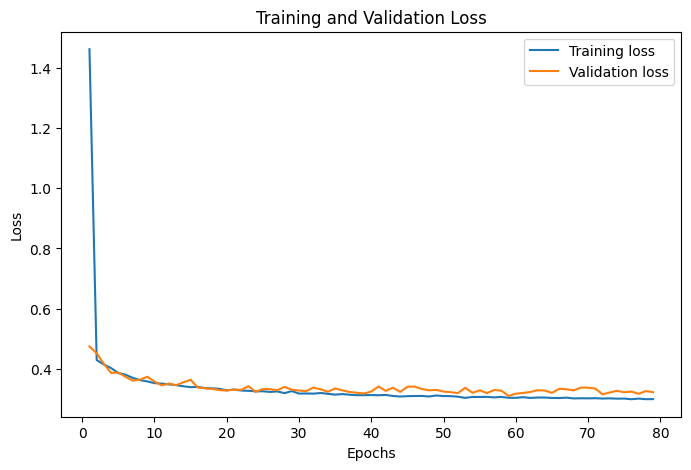

In [218]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

import matplotlib.pyplot as plt

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss,  label='Training loss')
plt.plot(epochs, val_loss,  label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [219]:
model.save("model.keras")